In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import larq_compute_engine as lce
import tensorflow as tf
import larq as lq
import numpy as np
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
# from tensorflow_model_optimization.python.core.keras.compat import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import random
tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from create_spectrogram import (
    create_spectrograms_from_audio_dataset, 
)
from helper_functions import (
    evaluate_prediction,
    get_file_size, 
    convert_bytes, 
    convert_prefetchdataset_to_numpy_arrays,
    predict_and_print_full_results,
    evaluate_time_of_prediction,
    full_int_model_predict,
    get_f1_scores_of_non_overlapping_partitions_full_int_q,
    get_f1_scores_of_bootstarping_partitions_full_int_q,
    )

2024-07-25 10:16:28.808144: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 10:16:28.840642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 10:16:28.840668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 10:16:28.841517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 10:16:28.846623: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 10:16:28.847134: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [8]:
sample_rate = 16000

In [9]:
train_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/training", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
test_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/testing", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
val_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/validation", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)

label_names = np.array(train_dataset.class_names)
print("Classes: ", label_names)

Found 11292 files belonging to 2 classes.
Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.
Classes:  ['non_target' 'target']


In [10]:
train_spectrogram_ds = create_spectrograms_from_audio_dataset(train_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = create_spectrograms_from_audio_dataset(test_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = create_spectrograms_from_audio_dataset(val_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)

x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

tf.Tensor([0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0], shape=(32,), dtype=int32)
0
tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
0
tf.Tensor([1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0], shape=(32,), dtype=int32)
1


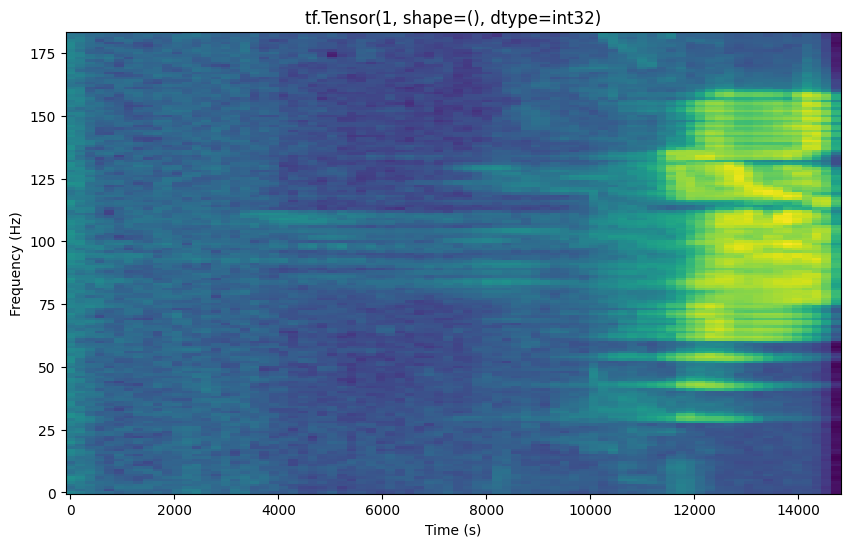

In [11]:
# non-target = 0, target = 1
# Print spectrograms of target or non-target class from dataset
class_number = 1

for i in train_spectrogram_ds:
    print(i[1])
    print(i[1][0].numpy())
    if i[1][0].numpy() == class_number:
        spectrogram = i[0][0]
        height = spectrogram.shape[0]
        width = spectrogram.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(X, Y, spectrogram)
        plt.title(i[1][0])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
        break

### HPO

In [12]:
class BinaryCNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = tf.keras.models.Sequential()
        
        # Hyperparameters
        num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)
        filters = [hp.Int(f'filters_{i}', min_value=2, max_value=8, step=2) for i in range(num_conv_layers)]
        kernel_size = hp.Choice('kernel_size', values=[2, 3, 5])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        
        # Model architecture
        model.add(lq.layers.QuantConv2D(
            filters=filters[0], kernel_size=(kernel_size, kernel_size),
            input_shape=self.input_shape,
            kernel_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False
        ))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.BatchNormalization(scale=False))

        # Tune number of layers
        for i in range(1, num_conv_layers):
            model.add(lq.layers.QuantConv2D(
                filters=filters[i], kernel_size=(kernel_size, kernel_size),
                kernel_quantizer="ste_sign",
                input_quantizer="ste_sign",
                use_bias=False
            ))
            model.add(tf.keras.layers.MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.BatchNormalization(scale=False))

        model.add(tf.keras.layers.Flatten())

        model.add(lq.layers.QuantDense(
            units=64,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False
        ))
        model.add(tf.keras.layers.BatchNormalization(scale=False))

        model.add(lq.layers.QuantDense(
            units=self.num_classes,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False
        ))
        model.add(tf.keras.layers.BatchNormalization(scale=False))
        model.add(tf.keras.layers.Activation("softmax"))
        
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"]
        )
        return model

input_shape = (184, 80, 1)
num_classes = 2

tuner = RandomSearch(
    BinaryCNNHyperModel(input_shape, num_classes),
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    # directory='my_dir',
    project_name='binary_cnn_tuning'
)

tuner.search(train_spectrogram_ds, epochs=1, validation_data=val_spectrogram_ds)


Trial 2 Complete [00h 00m 31s]
val_accuracy: 0.7699275314807892

Best val_accuracy So Far: 0.8612318933010101
Total elapsed time: 00h 01m 07s


In [13]:
best_model = tuner.get_best_models(num_models=1)[0]

Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
# Print the best hyperparameters
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
num_conv_layers: 2
filters_0: 6
kernel_size: 3
learning_rate: 0.004424632678209153
filters_1: 2


In [15]:
test_loss, test_acc = best_model.evaluate(x_test_np, y_test_np)

44/44 [==============================] - 1s 13ms/step - loss: 0.3317 - accuracy: 0.8981


### BNN model

In [16]:
# Following Larq's documentation model depth and parameters
model = tf.keras.models.Sequential()

# The first layer, only the weights are quantized while activations are left full-precision
model.add(lq.layers.QuantConv2D(4, (3, 3),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=(184, 80, 1)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# The second layer has both quantized weights and activations using the Straight-through-estimator sign activation technquie.
# Using straight-through-estimator to overcome undifferentiability issues
model.add(lq.layers.QuantConv2D(8, (3, 3), use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# The third layer following the second layer
# model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
# model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())
# The fourth layer
model.add(lq.layers.QuantDense(16, use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
model.add(tf.keras.layers.BatchNormalization(scale=False))
# The fifth layer
model.add(lq.layers.QuantDense(2, use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
model.add(tf.keras.layers.BatchNormalization(scale=False))
#Output layer, multi class classification
model.add(tf.keras.layers.Activation("softmax"))



#Compile and train the network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
# Evaluate the network
lq.models.summary(model)

+sequential_1 stats----------------------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                        x 1       x 1    (kB)                          |
+----------------------------------------------------------------------------------------------------------+
| quant_conv2d_2                   -  (-1, 182, 78, 4)       36         0    0.00           0       511056 |
| max_pooling2d_2                  -   (-1, 91, 39, 4)        0         0       0           0            0 |
| batch_normalization_4            -   (-1, 91, 39, 4)        0         8    0.03           0            0 |
| quant_conv2d_3                   1   (-1, 89, 37, 8)      288         0    0.04      948384            0 |
| max_pooling2d_3                  -   (-1, 44, 18, 8)        0         0       0           0            0 |
| batch_normalizati

In [18]:
model.fit(train_spectrogram_ds, epochs=1)

353/353 [==============================] - 13s 35ms/step - loss: 0.4386 - accuracy: 0.8171


In [20]:
test_loss, test_acc = model.evaluate(x_test_np, y_test_np)

44/44 [==============================] - 1s 15ms/step - loss: 0.4298 - accuracy: 0.8155


In [27]:
def display_weights(model):
    for layer in model.layers:
        if isinstance(layer, lq.layers.QuantConv2D) or isinstance(layer, lq.layers.QuantDense):
            weights = layer.get_weights()
            if weights:
                print(f"Layer: {layer.name}")
                for weight in weights:
                    print(f"Shape: {weight.shape}")
                    # Print the unique values to see if they are binarized
                    unique_values = np.unique(weight)
                    print(f"Unique values: {unique_values}\n")
                    # Print the first few weights for inspection
                    print(f"First few weights: {weight.flatten()[:10]}\n")

# Display the weights of the binarized CNN model


def model_memory_usage(model):
    import sys
    import larq as lq

    total_size = 0
    for layer in model.layers:
        if isinstance(layer, (lq.layers.QuantConv2D, lq.layers.QuantDense)):
            weights = layer.get_weights()
            for weight in weights:
                size = sys.getsizeof(weight)
                total_size += size
                print(f"Layer: {layer.name}, Weight shape: {weight.shape}, Size: {size} bytes")

    print(f"Total memory usage: {total_size} bytes")

# Display the weights of the binarized CNN model
display_weights(model)

# Check the memory usage of the model
model_memory_usage(model)

Layer: quant_conv2d_2
Shape: (3, 3, 1, 4)
Unique values: [-3.95377785e-01 -3.59072477e-01 -3.12955707e-01 -3.07287067e-01
 -3.03380311e-01 -2.58191824e-01 -2.33742028e-01 -2.09712073e-01
 -1.93024203e-01 -1.90692961e-01 -1.75967038e-01 -1.68013126e-01
 -1.24861211e-01 -1.11134268e-01 -9.09463167e-02 -8.10133591e-02
 -5.38455322e-02 -3.95821482e-02  1.44130492e-04  1.04729238e-03
  2.59656832e-02  9.93682817e-02  1.04678929e-01  1.11645766e-01
  1.12707481e-01  1.22400902e-01  1.61612168e-01  1.87013730e-01
  1.93578169e-01  2.03757524e-01  2.65140951e-01  3.02911460e-01
  3.08673501e-01  3.41712981e-01  3.48210782e-01  3.52318436e-01]

First few weights: [ 0.09936828 -0.08101336 -0.12486121 -0.23374203 -0.3033803  -0.1930242
  0.11270748 -0.03958215 -0.19069296 -0.05384553]

Layer: quant_conv2d_3
Shape: (3, 3, 4, 8)
Unique values: [-2.99159944e-01 -2.91951805e-01 -2.71072805e-01 -2.62876660e-01
 -2.50106096e-01 -2.48902619e-01 -2.46322647e-01 -2.37134144e-01
 -2.35796541e-01 -2.3312638

In [21]:
BASE_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/bnn/bnn_latent_weights.keras"
model.save(BASE_MODEL_FILE_NAME)
print("Model file name: ", BASE_MODEL_FILE_NAME)
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

Model file name:  spectrogram_models_from_notebooks/bnn/bnn_latent_weights.keras
File size: 1.23 Megabytes


### BNN binary weights

In [23]:
with lq.context.quantized_scope(True):
    model.save("spectrogram_models_from_notebooks/bnn/bnn_binary_weights.keras")  # save binarized weights h5
    weights = model.get_weights()  # get binarized weights

In [56]:
binarized_weights_model = tf.keras.models.load_model("spectrogram_models_from_notebooks/bnn/bnn_binary_weights.keras")

In [57]:
print("For Test dataset:")
evaluate_time_of_prediction(binarized_weights_model, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


For Test dataset:
Accuracy: 81.55%
Recall: 94.98%
Precision: 65.02%
F1-score: 77.20%

Time to make a prediction for a single data point
Mean: 0.056 seconds
Max: 0.488 seconds
Min: 0.05 seconds


In [1]:
# Display the weights of the binarized CNN model
display_weights(binarized_weights_model)

# Check the memory usage of the model
model_memory_usage(binarized_weights_model)

NameError: name 'display_weights' is not defined

In [44]:
print("Model file name: ", "spectrogram_models_from_notebooks/bnn/bnn_binary_weights.keras")
convert_bytes(get_file_size("spectrogram_models_from_notebooks/bnn/bnn_binary_weights.keras"), "MB")

Model file name:  spectrogram_models_from_notebooks/bnn/bnn_binary_weights.keras
File size: 1.23 Megabytes


### larq TFLite

In [60]:
lce_model = lce.convert_keras_model(model)

INFO:tensorflow:Assets written to: /tmp/tmp7wjkol6r/assets


INFO:tensorflow:Assets written to: /tmp/tmp7wjkol6r/assets
2024-07-24 23:44:55.680542: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7wjkol6r
2024-07-24 23:44:55.686482: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-07-24 23:44:55.686577: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp7wjkol6r
2024-07-24 23:44:55.688590: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 23:44:55.700275: I external/org_tensorflow/tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-07-24 23:44:5

In [67]:
test_point = x_test_np[:1]
test_point

array([[[[ 0.04401787],
         [ 0.39496595],
         [ 0.30142406],
         ...,
         [-1.0023309 ],
         [-1.6115078 ],
         [-3.336908  ]],

        [[ 0.06672598],
         [ 0.21323448],
         [ 0.49440995],
         ...,
         [-0.8302009 ],
         [-1.563447  ],
         [-3.236836  ]],

        [[-0.45135427],
         [-0.8405577 ],
         [-0.4890718 ],
         ...,
         [-0.8152356 ],
         [-1.5949649 ],
         [-3.111853  ]],

        ...,

        [[ 0.26997286],
         [ 0.5909237 ],
         [ 0.24076724],
         ...,
         [-0.7262548 ],
         [-1.5393718 ],
         [-3.0070517 ]],

        [[ 0.21380104],
         [ 1.0678476 ],
         [ 0.7340482 ],
         ...,
         [-0.6205487 ],
         [-1.543257  ],
         [-2.819945  ]],

        [[-0.23545307],
         [ 0.66171277],
         [ 0.6606401 ],
         ...,
         [-0.79505193],
         [-1.7219336 ],
         [-2.9889755 ]]]], dtype=float32)

In [75]:
exec_time = []
for i in range(1, len(x_test_np)):
    # print(i)
    start_time = time.time()
    interpreter = lce.testing.Interpreter(lce_model)
    y_pred_prob = interpreter.predict(x_test_np[i-1:i], verbose=0)
    y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
    stop_time = time.time() - start_time
    print(stop_time)
    exec_time.append(stop_time)
sum(exec_time) / len(exec_time)

0.0034351348876953125
0.005945444107055664
0.004619121551513672
0.004218578338623047
0.004244089126586914
0.003698110580444336
0.002618074417114258
0.0023539066314697266
0.002858400344848633
0.0025954246520996094
0.0027244091033935547
0.0025451183319091797
0.0026807785034179688
0.002638578414916992
0.002500295639038086
0.002559185028076172
0.00244140625
0.002485513687133789
0.002691030502319336
0.0024230480194091797
0.002576589584350586
0.0036363601684570312
0.0035359859466552734
0.004147529602050781
0.003807544708251953
0.003695964813232422
0.0025975704193115234
0.002474069595336914
0.0024585723876953125
0.002452373504638672
0.0025551319122314453
0.0024056434631347656
0.002532958984375
0.0024390220642089844
0.0026416778564453125
0.0026617050170898438
0.003058910369873047
0.002460956573486328
0.002381563186645508
0.002334117889404297
0.0023021697998046875
0.002269744873046875
0.0022895336151123047
0.003430604934692383
0.002691507339477539
0.002596616744995117
0.002526998519897461
0.002

0.00269923556125027

### tf TFLite

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(binarized_weights_model)
tflite_model = converter.convert()

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
    ) = predict_and_print_full_results(tflite_model, x_test_np, y_test_np, model_format="tf_lite")

print("\nTime for Test dataset:")
evaluate_time_of_prediction(tflite_model, x_test_np, y_test_np, model_format="tf_lite")

TF_LITE_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/bnn/bnn_mel_spec.tflite"
open(TF_LITE_MODEL_FILE_NAME, "wb").write(tflite_model)
print("\n")
print("Model file name: ", TF_LITE_MODEL_FILE_NAME)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

INFO:tensorflow:Assets written to: /tmp/tmp9r6jhc1m/assets


INFO:tensorflow:Assets written to: /tmp/tmp9r6jhc1m/assets
2024-07-24 23:22:50.729140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-07-24 23:22:50.729204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-07-24 23:22:50.729435: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9r6jhc1m
2024-07-24 23:22:50.733470: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-24 23:22:50.733504: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9r6jhc1m
2024-07-24 23:22:50.745406: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-07-24 23:22:50.811442: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9r6jhc1m
2024-07-24 23:22:50.841190: I tensorflow/cc/saved_model/loader.cc:316] SavedModel


Test dataset:
Basic assessment of the whole dataset (without any partitions):
Accuracy: 81.55%
Recall: 94.98%
Precision: 65.02%
F1-score: 77.20%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.7713843221729665

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.7676866511385799

Time for Test dataset:
Accuracy: 81.55%
Recall: 94.98%
Precision: 65.02%
F1-score: 77.20%

Time to make a prediction for a single data point
Mean: 0.001 seconds
Max: 0.003 seconds
Min: 0.001 seconds


Model file name:  spectrogram_models_from_notebooks/bnn/bnn_mel_spec.tflite
File size: 403.836 Kilobytes


In [47]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="spectrogram_models_from_notebooks/bnn/bnn_mel_spec.tflite")
interpreter.allocate_tensors()

# Get tensor details
tensor_details = interpreter.get_tensor_details()
for detail in tensor_details:
    print(f"Name: {detail['name']}, Index: {detail['index']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")

# Extract weights
for detail in tensor_details:
    tensor = interpreter.tensor(detail['index'])()
    print(f"Tensor {detail['name']} - Shape: {tensor.shape}, Data: {tensor}")

Name: serving_default_quant_conv2d_2_input:0, Index: 0, Shape: [  1 184  80   1], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_6/batchnorm/mul, Index: 1, Shape: [  16 6336], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_7/batchnorm/mul, Index: 2, Shape: [ 2 16], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_2/QuantConv2D, Index: 3, Shape: [4], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_2/QuantConv2D1, Index: 4, Shape: [4 3 3 1], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_3/QuantConv2D, Index: 5, Shape: [8], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_3/QuantConv2D1, Index: 6, Shape: [8 3 3 4], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_7/batchnorm/sub, Index: 7, Shape: [2], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_6/batchnorm/sub, Index: 8, Shape: [16], dtype: <class 'numpy.float32'>
Name: sequential_1/flatt

ValueError: Tensor data is null. Run allocate_tensors() first

In [41]:
dynamic_range_quant_converter = tf.lite.TFLiteConverter.from_keras_model(binarized_weights_model)
dynamic_range_quant_converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynamic_range_quant_model = dynamic_range_quant_converter.convert()

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
    ) = predict_and_print_full_results(dynamic_range_quant_model, x_test_np, y_test_np, model_format="tf_lite")

print("\nTime for Test dataset:")
evaluate_time_of_prediction(dynamic_range_quant_model, x_test_np, y_test_np, model_format="tf_lite")

DRQ_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/bnn/bnn_mel_spec_drq.tflite"
open(DRQ_MODEL_FILE_NAME, "wb").write(dynamic_range_quant_model)
print("\n")
print("Model file name: ", DRQ_MODEL_FILE_NAME)
convert_bytes(get_file_size(DRQ_MODEL_FILE_NAME), "KB")

INFO:tensorflow:Assets written to: /tmp/tmp40el20ai/assets


INFO:tensorflow:Assets written to: /tmp/tmp40el20ai/assets
2024-07-24 23:20:55.575793: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-07-24 23:20:55.575870: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-07-24 23:20:55.576047: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp40el20ai
2024-07-24 23:20:55.578024: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-24 23:20:55.578048: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp40el20ai
2024-07-24 23:20:55.583628: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-07-24 23:20:55.631920: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp40el20ai
2024-07-24 23:20:55.652062: I tensorflow/cc/saved_model/loader.cc:316] SavedModel


Test dataset:
Basic assessment of the whole dataset (without any partitions):
Accuracy: 81.55%
Recall: 94.98%
Precision: 65.02%
F1-score: 77.20%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.7713843221729665

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.7611104028344549

Time for Test dataset:
Accuracy: 81.55%
Recall: 94.98%
Precision: 65.02%
F1-score: 77.20%

Time to make a prediction for a single data point
Mean: 0.001 seconds
Max: 0.003 seconds
Min: 0.001 seconds


Model file name:  spectrogram_models_from_notebooks/bnn/bnn_mel_spec_drq.tflite
File size: 106.914 Kilobytes


In [42]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=dynamic_range_quant_model)
interpreter.allocate_tensors()

# Get tensor details
tensor_details = interpreter.get_tensor_details()
for detail in tensor_details:
    print(f"Name: {detail['name']}, Index: {detail['index']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")

# Extract weights
for detail in tensor_details:
    tensor = interpreter.tensor(detail['index'])()
    print(f"Tensor {detail['name']} - Shape: {tensor.shape}, Data: {tensor}")

Name: serving_default_quant_conv2d_2_input:0, Index: 0, Shape: [  1 184  80   1], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_5/FusedBatchNormV3, Index: 1, Shape: [8], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_5/FusedBatchNormV31, Index: 2, Shape: [8], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_4/FusedBatchNormV3, Index: 3, Shape: [4], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_4/FusedBatchNormV31, Index: 4, Shape: [4], dtype: <class 'numpy.float32'>
Name: sequential_1/quant_conv2d_2/QuantConv2D/ste_sign_7/add/y, Index: 5, Shape: [], dtype: <class 'numpy.float32'>
Name: sequential_1/flatten_1/Const, Index: 6, Shape: [2], dtype: <class 'numpy.int32'>
Name: sequential_1/batch_normalization_6/batchnorm/sub, Index: 7, Shape: [16], dtype: <class 'numpy.float32'>
Name: sequential_1/batch_normalization_7/batchnorm/sub, Index: 8, Shape: [2], dtype: <class 'numpy.float32'>
Name: sequentia

ValueError: Tensor data is null. Run allocate_tensors() first

In [48]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_val_np).batch(1).take(100):
    yield [input_value]

full_int_converter = tf.lite.TFLiteConverter.from_keras_model(binarized_weights_model)
full_int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
full_int_converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
full_int_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
full_int_converter.inference_input_type = tf.uint8
full_int_converter.inference_output_type = tf.uint8

tflite_model_quant = full_int_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpwa6fnxxc/assets


INFO:tensorflow:Assets written to: /tmp/tmpwa6fnxxc/assets
/home/polina/newname/.venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-07-24 23:27:24.040662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-07-24 23:27:24.040728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-07-24 23:27:24.040939: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwa6fnxxc
2024-07-24 23:27:24.043069: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-24 23:27:24.043128: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpwa6fnxxc
2024-07-24 23:27:24.049133: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-07-24 23:27

In [49]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [50]:
# Load TFLite model and allocate tensors
# interpreter = tf.lite.Interpreter(model_content=dynamic_range_quant_model)
interpreter.allocate_tensors()

# Get tensor details
tensor_details = interpreter.get_tensor_details()
for detail in tensor_details:
    print(f"Name: {detail['name']}, Index: {detail['index']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")

# Extract weights
for detail in tensor_details:
    tensor = interpreter.tensor(detail['index'])()
    print(f"Tensor {detail['name']} - Shape: {tensor.shape}, Data: {tensor}")

Name: serving_default_quant_conv2d_2_input:0, Index: 0, Shape: [  1 184  80   1], dtype: <class 'numpy.uint8'>
Name: sequential_1/flatten_1/Const, Index: 1, Shape: [2], dtype: <class 'numpy.int32'>
Name: sequential_1/batch_normalization_7/batchnorm/sub, Index: 2, Shape: [2], dtype: <class 'numpy.int32'>
Name: sequential_1/batch_normalization_7/batchnorm/mul, Index: 3, Shape: [ 2 16], dtype: <class 'numpy.int8'>
Name: sequential_1/batch_normalization_6/batchnorm/sub, Index: 4, Shape: [16], dtype: <class 'numpy.int32'>
Name: sequential_1/batch_normalization_6/batchnorm/mul, Index: 5, Shape: [  16 6336], dtype: <class 'numpy.int8'>
Name: sequential_1/batch_normalization_5/FusedBatchNormV31, Index: 6, Shape: [8], dtype: <class 'numpy.int8'>
Name: sequential_1/batch_normalization_5/FusedBatchNormV3, Index: 7, Shape: [8], dtype: <class 'numpy.int8'>
Name: sequential_1/quant_conv2d_3/QuantConv2D, Index: 8, Shape: [8], dtype: <class 'numpy.int32'>
Name: sequential_1/quant_conv2d_3/QuantConv2D1

ValueError: Tensor data is null. Run allocate_tensors() first

In [58]:
import pathlib
import time

tflite_models_dir = pathlib.Path("spectrogram_models_from_notebooks/bnn")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"bnn_mel_spec_16kHz_full_int_q.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

111696

In [59]:
print("Validation dataset:")
predictions = full_int_model_predict(tflite_model_quant_file, x_val_np)
evaluate_prediction(y_val_np, predictions)

print("\nDevide dataset into 10 non-overlapping patritions and get their mean F1-score")
non_overlap_patritions_f1_scores = get_f1_scores_of_non_overlapping_partitions_full_int_q(tflite_model_quant_file, x_val_np, y_val_np)
print("Non-overlap mean F1-score: ", np.mean(non_overlap_patritions_f1_scores))

print("\nGet 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score")
bootstrap_patritions_f1_scores = get_f1_scores_of_bootstarping_partitions_full_int_q(tflite_model_quant_file, x_val_np, y_val_np)
print("Bootstrap mean F1-score: ", np.mean(bootstrap_patritions_f1_scores))



print("\nTest dataset:")
predictions = full_int_model_predict(tflite_model_quant_file, x_test_np)
evaluate_prediction(y_test_np, predictions)

print("\nDevide dataset into 10 non-overlapping patritions and get their mean F1-score")
non_overlap_patritions_f1_scores = get_f1_scores_of_non_overlapping_partitions_full_int_q(tflite_model_quant_file, x_test_np, y_test_np)
print("Non-overlap mean F1-score: ", np.mean(non_overlap_patritions_f1_scores))

print("\nGet 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score")
bootstrap_patritions_f1_scores = get_f1_scores_of_bootstarping_partitions_full_int_q(tflite_model_quant_file, x_test_np, y_test_np)
print("Bootstrap mean F1-score: ", np.mean(bootstrap_patritions_f1_scores))

print("\nTime for Test dataset:")
time_data = []
for data_point in x_test_np:
    start_time = time.time()
    predictions = full_int_model_predict(tflite_model_quant_file, [data_point])
    elapsed_time = time.time() - start_time
    time_data.append(elapsed_time)
print("\nTime to make a prediction for a single data point")
print(f"Mean: {round(np.mean(time_data), 3)} seconds")
print(f"Max: {round(np.max(time_data), 3)} seconds")
print(f"Min: {round(np.min(time_data), 3)} seconds")

convert_bytes(get_file_size(tflite_model_quant_file), "KB")

Validation dataset:
Accuracy: 80.51%
Recall: 95.55%
Precision: 64.52%
F1-score: 77.03%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.76903113936507

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.7633565261827667

Test dataset:
Accuracy: 80.69%
Recall: 95.85%
Precision: 63.72%
F1-score: 76.55%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.7643452994165095

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.7715132049712021

Time for Test dataset:

Time to make a prediction for a single data point
Mean: 0.002 seconds
Max: 0.005 seconds
Min: 0.001 seconds
File size: 109.078 Kilobytes
